In [92]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

In [93]:
import getpass 
import os

In [94]:
from dotenv import load_dotenv
load_dotenv()

# store api key in environment variable
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

In [95]:
class State(TypedDict):

    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [96]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17")

In [ ]:
from tools import search_tool, make_campaign, make_ad_set, make_ad_creative, make_ad, make_ad_image 

tools = [search_tool, make_campaign, make_ad_set, make_ad_creative, make_ad, make_ad_image]

In [98]:
llm_with_tools = llm.bind_tools(tools)

In [99]:
from agent import agent

In [ ]:
def chatbot_with_tools(state: State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [101]:
graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)

In [102]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tool requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message  = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"])
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call['name'],
                    tool_call_id = tool_call['id'],
                )
            )
        return {"messages": outputs}

In [103]:
tool_node = BasicToolNode(tools = tools)

In [104]:
graph_builder.add_node("tools", tool_node)

In [105]:
def route_tools(state: State):
    """ used in conditional_edge to route to the ToolNode if the last message has tool calls.
    Otherwise route to the end."""

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls)>0:
        return "tools"
    return END

In [106]:
graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    route_tools,
    #define the output to a specific node in graph
    {"tools": "tools", END: END},
)

In [107]:
graph_builder.add_edge("tools", "chatbot_with_tools")
graph_builder.add_edge(START, "chatbot_with_tools")

In [ ]:
graph = graph_builder.compile()

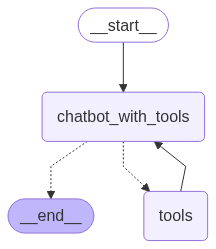

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png(max_retries=2)))
except Exception as e:
    print(e)

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break